In [1]:
from pathlib import Path 
import pandas as pd
import gzip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans

## A bit of biological context

What is TCGA ? 
The Cancer Genome Atlas (TCGA), is a landmark cancer genomics program, molecularly characterized over 20,000 primary cancer and matched normal samples spanning 33 cancer types. This joint effort between NCI and the National Human Genome Research Institute began in 2006, bringing together researchers from diverse disciplines and multiple institutions.

Over the next dozen years, TCGA generated over 2.5 petabytes of genomic, epigenomic, transcriptomic, and proteomic data. The data, which has already led to improvements in our ability to diagnose, treat, and prevent cancer, will remain publicly available for anyone in the research community to use.

The goal of this tutorial is to classify 5 types of cancers from TCGA based on the gene expression.

## Dataset gene expression of PRAD

Prostatic adenocarcinoma (PRAD) is the most common form of cancer in men.

### Take a Look

The first thing you might want to do is see if your data made it into the dataframe as you intended.

The quickest way to take a look at your data is to use the head() or tail() functions, which print out the first or last few rows of the dataframe.

To check that the entire data was loaded we can use the function df.shape, where df is the generic name given to the dataframe created, giving us the number of rows and columns the dataframe contains. Then we can look at the actual dataframe through the df.head(n=5), where n is the number of rows we want to display and is by default 5

In [420]:
#read the file classification_data_PRAD.csv from the data folder
classification_PRAD = pd.read_csv(Path(f'/Users/hhudson/Downloads/classification_data_PRAD.csv'))

In [ ]:
# show the first 5 lines
classification_PRAD[:5]

,cancer,5_8S_rRNA,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3
0,PRAD,9.871674,10.268249,14.498715,15.493247,15.251819,9.871674,20.614640,16.626832,13.212550,...,14.201815,15.923901,16.878908,14.425027,9.871674,17.470557,19.079302,9.871674,17.860232,17.131954
1,PRAD,9.871674,9.871674,15.846357,15.356124,14.775038,14.136728,23.267677,20.484921,11.816599,...,13.761663,16.433463,15.904350,12.700507,9.871674,17.417111,20.163621,9.871674,17.674168,17.716726
2,PRAD,10.135789,10.226848,12.767330,13.064908,13.680148,10.244671,21.397172,16.097640,13.152658,...,14.991922,16.313903,16.889105,14.940678,9.871674,17.584533,19.108095,9.871674,18.301813,17.567869
3,PRAD,9.871674,10.196215,14.083221,14.734234,14.851239,10.105320,20.413462,15.825515,12.415391,...,15.015269,16.727496,16.559719,14.551295,9.871674,17.505029,18.791579,9.871674,18.070571,18.066707
4,PRAD,9.871674,10.169684,13.889989,12.909670,13.391581,9.871674,22.894378,16.877373,12.806289,...,15.921991,16.910553,16.733921,12.831586,9.871674,18.176938,19.119398,9.871674,18.797130,17.734499


In [ ]:
# show the shape of the dataframe (number of columns and line)
classification_PRAD.shape

(505, 56137)

### Analysis

An important start to our analysis is to get some descriptive statistics for our dataframe. If what we care about is the statistics of specific genes across the different samples, then our dataframe is already perfectly set for us to use the df.describe() function, which provide the general statistical values of columns (i.e., mean, sd, min, max, …).

In [ ]:
# show the general statistics of the data set. How does the statistic varies between genes ?
classification_PRAD.describe()
"""The count of each gene is constant for all, however since the maximums and minimums can be seen to differ, the rest of their data does as well, causing differnt means, standard deviations, and quartiles."""

,5_8S_rRNA,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,...,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,9.876574,10.077694,14.368984,13.463428,14.036549,10.870187,21.221864,16.405930,12.912305,11.366432,...,14.977308,16.413922,16.989327,14.113253,9.874428,17.577038,19.117320,9.872338,18.046811,17.709906
std,0.042020,0.224658,2.185384,1.081436,0.611884,1.229232,0.984969,0.978583,1.188776,0.396016,...,0.576781,0.402629,0.420477,1.071989,0.035782,0.463039,0.651508,0.014931,0.495548,0.409973
min,9.871674,9.871674,11.909280,10.892505,11.974376,9.871674,18.474710,14.000258,10.169949,9.871674,...,12.811539,13.775972,15.659155,10.963466,9.871674,16.278426,16.278027,9.871674,16.740303,16.219719
25%,9.871674,9.871674,13.068114,12.683386,13.613684,10.268383,20.549305,15.772100,12.040221,11.169212,...,14.623465,16.164639,16.737949,13.449332,9.871674,17.310534,18.677343,9.871674,17.699360,17.459454
50%,9.871674,10.071298,13.824569,13.333451,13.965551,10.541024,21.210684,16.294464,12.790729,11.399169,...,15.027054,16.418839,16.970942,14.117364,9.871674,17.561146,19.124879,9.871674,18.053884,17.705407
75%,9.871674,10.241022,14.959867,14.137039,14.430312,10.868850,21.885972,16.920761,13.641783,11.615209,...,15.370702,16.669493,17.219196,14.804827,9.871674,17.864537,19.544959,9.871674,18.370606,17.963156
max,10.307029,11.779189,29.493729,17.352366,16.260666,16.922232,24.713444,21.072509,18.245754,13.076803,...,16.488563,17.479991,18.582234,17.290074,10.383500,18.858377,21.341761,10.207202,19.733523,19.676984


We can now see the general descriptive statistics and summary of the genes dataframe for the different samples

### Visualisation

We can create some visualizations for the statistics that would paint a better picture of the gene data. One of the basic ways to accomplish this would be through some histograms for the individual genes. Now, our data constains quite a large amount of columns (genes) and as a result would be best to focus on individual or smaller subset groups when creating histograms for them.

Pandas has a quick integrated set of plotting functions, among which we can plot histograms with the function hist. Like said before, we will create a histogram for one for one of the genes, in this case genes 'GK3P','LARP4B' and 'OIP5' which we'll subset from the main dataframe.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9217948/


In [421]:
# plot the histogram of the three genes. How do the distribution varies ? Mean ? Image of what it should look like to
df = pd.DataFrame(classification_PRAD)


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

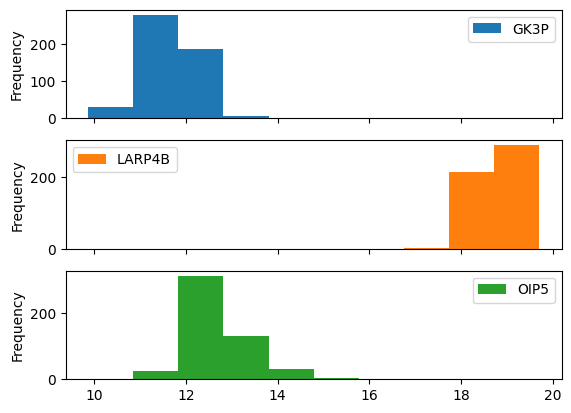

In [ ]:
df.plot(y=['GK3P', 'LARP4B', 'OIP5'], kind='hist', subplots=True)
# df.hist(column='GK3P')
# df.hist(column='LARP4B', color='green')
# df.hist(column='OIP5', color='red')

![Alt text](images/Capture%20d%E2%80%99e%CC%81cran%202023-06-05%20a%CC%80%2016.17.19.png)

This is a great start to get a better picture of the gene data. The pandas plotting function can take more arguments and create cleaner figures if so desired, but for better and more complex figures we will move one to using libraries like Matplotlib and Seaborn.

### Seaborn and Matplotlib

The basic plotting library in python is matplotlib and a lot can be accomplished with its integrated functions, depending on how much you are willing to work to get it exactly how you want. Given that we are interested in statistical visualizations, we are going to work with the seaborn library:

Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

Alright so let's try to make a better histogram, or distribution plots, than the basic ones we did before.

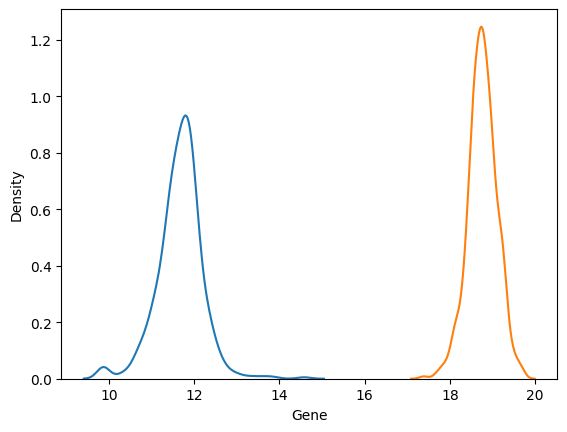

In [427]:
# selecting the same genes ('GK3P','LARP4B','OIP5') and plotting them in the same figure
i = 0
for gene in ['GK3P','LARP4B','OIP5']:
    ax3 = sns.kdeplot(df[gene])
    ax3.set(xlabel='Gene')
    if i == 1:
        break
    i += 1
    
# To conveniently plot each column [gene] selected, we'll use a 'for loop'
# otherwise we would have to manually code each column name. The example only uses 3 columns
# but if we had much more columns this becomes time consuming, so the 'for loop' automates the process.

![Alt text](images/Capture%20d%E2%80%99e%CC%81cran%202023-06-05%20a%CC%80%2016.19.27.png)

This is already an improvement from the plots we did through pandas and matplotlib earlier. We now have all three gene counts plotted on the same plane, which can make comparing the distribution easier. Seaborn also automatically asigns colors to differentiate each gene count.


### Plot Observations

Gene LARP4B, shows a different distribution and higher mean than the other two and if we knew more information about each gene could lead to more interesting research. 
More aesthetic improvements can be accomplished, and we'll leave that for you to explore. For now we will try some more seaborn plots and improving aesthetics in those.


Let's now do a simple visualization to check how the gene sequece shows in the samples. Let's first do a simple plot looking at the first sample, sample_0 and we'll plot the sample's gene values in a scatter plot.

To do this we first however need the samples to go from being the row values into being the columns, since our plotting libraries need the input to be in vectors/series/arrays. This is accomplished very easily once your data is in a pandas dataframe by transposing the dataframe.

In [22]:
# transpose the data frame
df_t = df.transpose()

NameError: name 'df' is not defined

In [ ]:
df_t

,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,500,501,502,503,504
cancer,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,...,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD,PRAD
5_8S_rRNA,9.871674,9.871674,10.135789,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,...,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674
5S_rRNA,10.268249,9.871674,10.226848,10.196215,10.169684,9.871674,9.871674,10.189375,10.345953,10.125018,...,9.999893,10.10527,10.018462,9.871674,9.871674,9.871674,9.871674,9.871674,10.304552,10.15673
7SK,14.498715,15.846357,12.76733,14.083221,13.889989,14.744716,14.170361,12.224751,13.577137,13.610987,...,15.515754,13.610609,13.947539,13.333442,12.988546,13.507351,12.764106,14.2956,16.915563,16.766944
A1BG,15.493247,15.356124,13.064908,14.734234,12.90967,15.36184,14.153695,12.844435,13.852981,14.34248,...,15.299908,15.621225,14.461535,13.039519,13.618437,12.86217,10.943915,13.706396,13.69015,12.223513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,17.470557,17.417111,17.584533,17.505029,18.176938,17.816464,18.357973,18.076289,17.144837,17.906049,...,17.736389,17.815895,17.234131,17.620043,17.363693,17.317806,17.825662,17.479722,17.499598,17.826126
ZYX,19.079302,20.163621,19.108095,18.791579,19.119398,18.566131,18.357702,19.11267,19.106018,19.644582,...,19.629273,19.77782,19.860156,18.925,19.526515,18.33886,18.462881,19.276954,19.905594,18.199068
ZYXP1,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,...,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674,9.871674
ZZEF1,17.860232,17.674168,18.301813,18.070571,18.79713,18.42928,18.665939,18.20955,17.661276,17.995757,...,18.155679,18.043,17.39547,18.354455,18.024401,17.096107,18.758271,18.100769,18.020329,18.030797


In [ ]:
#select the first column. The first column represents the first sample
#One may use the iloc function
first_column = df_t.iloc[1:,0]
first_column

5_8S_rRNA     9.871674
5S_rRNA      10.268249
7SK          14.498715
A1BG         15.493247
A1BG-AS1     15.251819
               ...    
ZYG11B       17.470557
ZYX          19.079302
ZYXP1         9.871674
ZZEF1        17.860232
ZZZ3         17.131954
Name: 0, Length: 56136, dtype: object

<Axes: ylabel='0'>

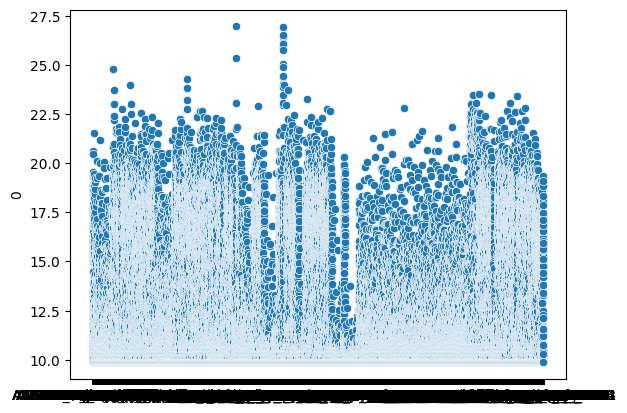

In [ ]:
# plot it with seaborn scatter plot 
# takes few minutes since there are many points
sns.scatterplot(first_column)


![Alt text](images/Capture%20d%E2%80%99e%CC%81cran%202023-06-05%20a%CC%80%2016.20.21.png)

## ML Classification inspired from breast classification

### Visualisation

In [2]:
classification_all = pd.read_csv(Path(f'/Users/hhudson/Downloads/classification_data_all.csv'))
classification_all

,cancer,5_8S_rRNA,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3
0,PRAD,9.871674,10.268249,14.498715,15.493247,15.251819,9.871674,20.614640,16.626832,13.212550,...,14.201815,15.923901,16.878908,14.425027,9.871674,17.470557,19.079302,9.871674,17.860232,17.131954
1,PRAD,9.871674,9.871674,15.846357,15.356124,14.775038,14.136728,23.267677,20.484921,11.816599,...,13.761663,16.433463,15.904350,12.700507,9.871674,17.417111,20.163621,9.871674,17.674168,17.716726
2,PRAD,10.135789,10.226848,12.767330,13.064908,13.680148,10.244671,21.397172,16.097640,13.152658,...,14.991922,16.313903,16.889105,14.940678,9.871674,17.584533,19.108095,9.871674,18.301813,17.567869
3,PRAD,9.871674,10.196215,14.083221,14.734234,14.851239,10.105320,20.413462,15.825515,12.415391,...,15.015269,16.727496,16.559719,14.551295,9.871674,17.505029,18.791579,9.871674,18.070571,18.066707
4,PRAD,9.871674,10.169684,13.889989,12.909670,13.391581,9.871674,22.894378,16.877373,12.806289,...,15.921991,16.910553,16.733921,12.831586,9.871674,18.176938,19.119398,9.871674,18.797130,17.734499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,COAD,10.250527,10.250527,14.844345,12.743746,11.785142,16.401606,18.414332,14.193771,10.838938,...,13.946958,15.371379,15.817838,10.754458,10.250527,15.964175,18.844931,10.250527,15.637150,17.443223
3214,COAD,10.250527,10.525560,12.509902,12.805544,13.157337,16.377583,19.023303,13.874232,10.335520,...,14.105201,15.487291,16.714073,10.809814,10.250527,16.065341,19.156018,10.250527,16.667582,17.137284
3215,COAD,10.250527,10.250527,11.411071,13.448918,12.972836,16.782528,18.392489,14.915808,11.082798,...,14.002977,15.511995,16.803226,10.250527,10.250527,15.591803,19.289836,10.250527,16.819258,16.404087
3216,COAD,10.250527,10.250527,13.974530,13.568006,13.200927,14.701427,19.469029,14.533315,11.121367,...,13.637085,15.257130,16.507671,10.250527,10.250527,15.504103,20.171272,10.250527,16.590131,15.952444


Let's see the number of cancers represented in the dataset. One can use the function pandas groupby and keep the first element 

In [37]:
# how many cancer types are present in this dataset? 
classification_all.groupby(['cancer'])['cancer'].count()

cancer
BRCA    1127
COAD     503
KIRC     543
LUAD     540
PRAD     505
Name: cancer, dtype: int64

Let's see how gene expression changes over the five cancer. 

Plot for the 5 cancer the 3 previously studied gene expression

<Axes: xlabel='OIP5', ylabel='Density'>

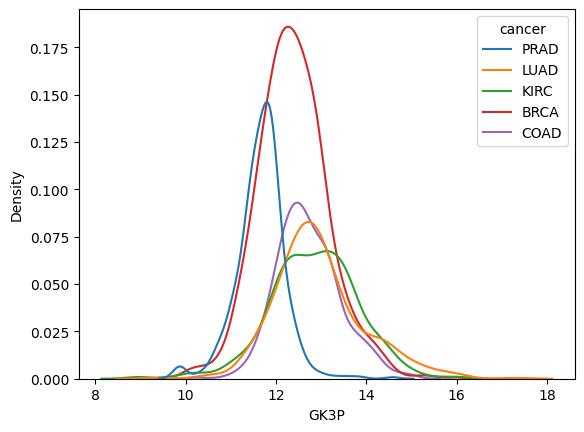

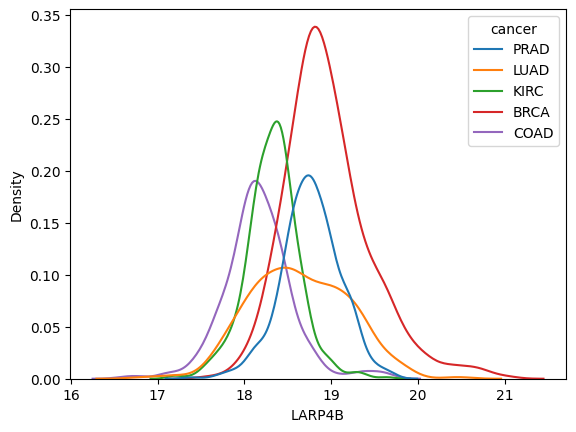

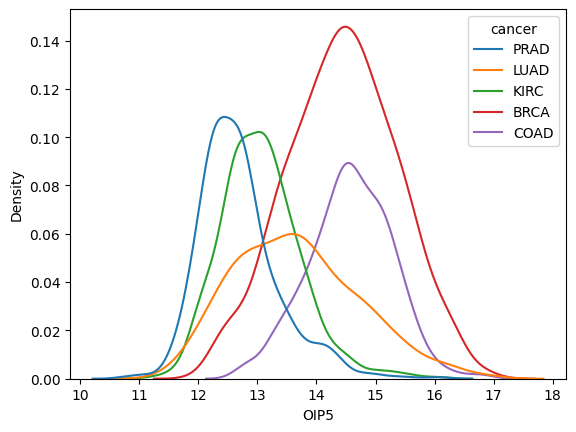

In [413]:
# selecting the same genes ('GK3P','LARP4B','OIP5') and plotting them in the same figure
# for cancer in ['BRCA','COAD','KIRC', 'LUAD','PRAD']:
#     sns.kdeplot(df['cancer'])
gene_list = ['GK3P','LARP4B','OIP5']
cancer_count = classification_all.groupby(['cancer']).count()
plt.figure()
sns.kdeplot(data=classification_all, x='GK3P', hue='cancer')
plt.figure()
sns.kdeplot(data=classification_all, x='LARP4B', hue='cancer')
plt.figure()
sns.kdeplot(data=classification_all, x='OIP5', hue='cancer')
# sns.kdeplot(classification_all.groupby(['cancer'])['GK3P'])
#classification_all.loc[:, gene_list].iloc[1:, :].groupby(['cancer'])
#sns.kdeplot(classification_all.iloc[3].groupby(['cancer']))
# sns.kdeplot(column='LARP4B', color='green')
# sns.kdeplot(column='OIP5', color='red')

One plot should look like the following figure

![Alt text](images/Capture%20d%E2%80%99e%CC%81cran%202023-06-05%20a%CC%80%2016.47.37.png)

### Classification task

Now, let's use all the knowledge you've gather to classify these samples i.e try to find the type of cancer from the gene expression

Here are a few steps that we would like to see for the task: 
- a bit of data reduction of dimensionality. We are working with vectors of 55692 elements, which might lead to overfitting. A few ideas of dimensionality reduction: only select the most variant genes between samples, PCA
- some classification model comparisons (kmean, knn and logistic regression and more!)
- compare the results of the models (which metric would you use?)
- what is your opinion on the results

In [4]:
data = classification_all.iloc[:, 1:]
target = classification_all.iloc[:, 0]
scaled_data = StandardScaler().fit_transform(data)
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(scaled_data)
X_train, X_test, y_train, y_test = train_test_split(reduced_data, target, test_size=0.3)

### KNN Classification

KNN Classification works by first fitting the data with the target values, and then when predicting the model uses the given number of neighbors in order to compare the data point's to that number of neighbors in order to vote on which target values are more prominent with said neighbors and then assigning that target value to the data point.

In [89]:
skf = StratifiedShuffleSplit(n_splits=5, random_state=0)
KNN_accuracies = []
other_p_value = []
for i, (train_index, test_index) in enumerate(skf.split(data, target)):
    KNN = KNeighborsClassifier(n_neighbors=10, p=1) 
    KNN.fit(reduced_data[train_index], target.iloc[train_index])
    KNN_scores = KNN.score(reduced_data[test_index], target.iloc[test_index])
    KNN_accuracies.append(KNN_scores)
    KNN2 = KNeighborsClassifier(n_neighbors=10, p=1) 
    KNN2.fit(reduced_data[train_index], target.iloc[train_index])
    KNN_scores = KNN2.score(reduced_data[test_index], target.iloc[test_index])
    other_p_value.append(KNN_scores)
print(KNN_accuracies)
print(other_p_value)

[1.0, 0.9968944099378882, 0.9968944099378882, 0.9968944099378882, 0.9937888198757764]
[1.0, 0.9968944099378882, 0.9968944099378882, 0.9968944099378882, 0.9937888198757764]


### Logistic Regression Classification

Logistic Regression Classification works by taking the fitted data points, and generating a curve based on the trends present within those data points; the model then applies the values that it is predicting to the equation of the curve which then produces the corresponding target value.

In [90]:
skf_reg = StratifiedShuffleSplit(n_splits=5, random_state=0)
logreg_accuracies = []
for i, (train_index, test_index) in enumerate(skf_reg.split(data, target)):
    regression_data = LogisticRegression().fit(reduced_data[train_index], target.iloc[train_index])
    logreg_accuracies.append(regression_data.score(reduced_data[test_index], target.iloc[test_index]))
logreg_accuracies
# accuracy_logreg =  regression_data.score(X_test, y_test)

/Users/hhudson/anaconda3/envs/owkin1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hhudson/anaconda3/envs/owkin1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

[1.0, 1.0, 0.9968944099378882, 1.0, 0.9968944099378882]

### Random Forest Classification

Random Forest Classification uses numerous decision trees each with their own probabilities of a certain cancer type being the unknown target value for the data point, are averaged in order to predict which cancer type is correct.

In [88]:
skf_reg = StratifiedShuffleSplit(n_splits=5, random_state=0)
rfc_accuracies = []
for i, (train_index, test_index) in enumerate(skf_reg.split(data, target)):
    rfc = RandomForestClassifier()
    rfc.fit(reduced_data[train_index], target.iloc[train_index])
    rfc_accuracies.append(rfc.score(reduced_data[test_index], target.iloc[test_index]))
rfc_accuracies

[1.0, 1.0, 1.0, 0.9968944099378882, 0.9937888198757764]

### Naive Bayes Classification

Naive Bayes Classification uses the probabilities of gene expressions levels from the training data, to compare a given expression level with its probability of being one of the five types of cancers present in the data set. 

In [87]:
skf_NB = StratifiedShuffleSplit(n_splits=5, random_state=0)
NB_accuracies = []
for i, (train_index, test_index) in enumerate(skf_NB.split(data, target)):
    NB = BernoulliNB()
    NB.fit(reduced_data[train_index], target.iloc[train_index])
    NB_accuracies.append(NB.score(reduced_data[test_index], target.iloc[test_index]))
    NB_prediction = NB.predict(reduced_data[train_index])
NB_accuracies
NB_prediction

array(['COAD', 'PRAD', 'PRAD', ..., 'LUAD', 'KIRC', 'LUAD'], dtype='<U4')

### Support Vector Machines

Support vector machines classify by increasing the dimensions of the data until a support vector classifier can seperate the data points with different targets, it then will classify a point that's target value is unknown by comparing its orientation to that of the supper vector classifier.

In [414]:
skf_svm = StratifiedShuffleSplit(n_splits=5, random_state=0)
svm_accuracies = []
for i, (train_index, test_index) in enumerate(skf_svm.split(data, target)):
    svm_class = SVC().fit(reduced_data[train_index], target.iloc[train_index])
    score_svm = svm_class.score(reduced_data[test_index], target.iloc[test_index])
    svm_accuracies.append(score_svm)
svm_accuracies

[1.0, 1.0, 0.9968944099378882, 0.9968944099378882, 0.9937888198757764]

### KMeans Classification

In [44]:
#split data into the amount of cancer groups
#perform kmeans on each group
# transposed = classification_all.transpose()
# transposed.filter(like='PRAD')
# grouped_by_cancer = classification_all.groupby('cancer')
# for group in grouped_by_cancer.groups:
#     split_data_group = grouped_by_cancer.get_group(group)
#     KM = KMeans(n_clusters=10, random_state=0).fit(split_data_group[:, 1:])
    
# accuracy_KMean = 

KM = KMeans(n_clusters=5, random_state=0).fit(X_train)
KM.score(X_test, y_test)
print(KM.predict(X_test)[:11])
print(y_test[:11])

/Users/hhudson/anaconda3/envs/owkin1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[2 0 0 3 1 0 1 4 0 2 2]
1789    BRCA
381     PRAD
453     PRAD
2730    COAD
707     LUAD
10      PRAD
1028    LUAD
1329    KIRC
476     PRAD
1754    BRCA
2275    BRCA
Name: cancer, dtype: object


### Boxplot Accuracy Comparison

AttributeError: 'Text' object has no attribute 'set_xticklabels'

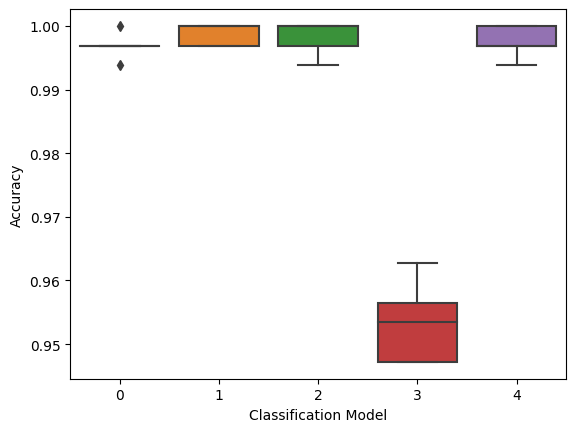

In [432]:
all_accuracies = [KNN_accuracies, logreg_accuracies, rfc_accuracies, NB_accuracies, svm_accuracies]
model_names = ('KNN', 'LogisticRegression', 'RandomForestClassifier', 'Naive Bayes')
ax5 = sns.boxplot(all_accuracies).set(xlabel='Classification Model', ylabel='Accuracy')
ax5[0].set_xticklabels(["KNN", "LogisticRegression", "RandomForestClassifier", "Naive Bayes", "SVM"], rotation=45)

[Text(0.5, 0, 'Classification Model'), Text(0, 0.5, 'Accuracy')]

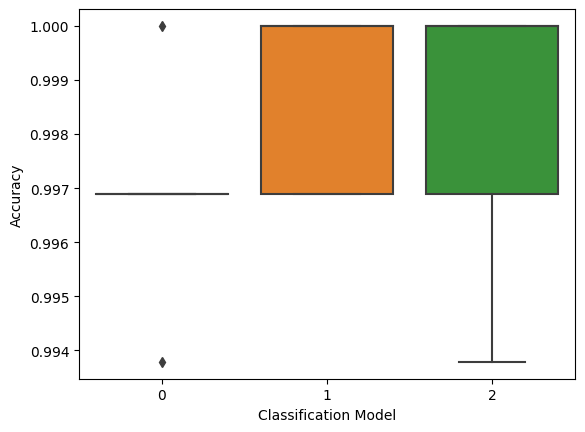

In [93]:
sns.boxplot(all_accuracies[0:3]).set(xlabel='Classification Model', ylabel='Accuracy')

[Text(0.5, 0, 'Classification Model'), Text(0, 0.5, 'Accuracy')]

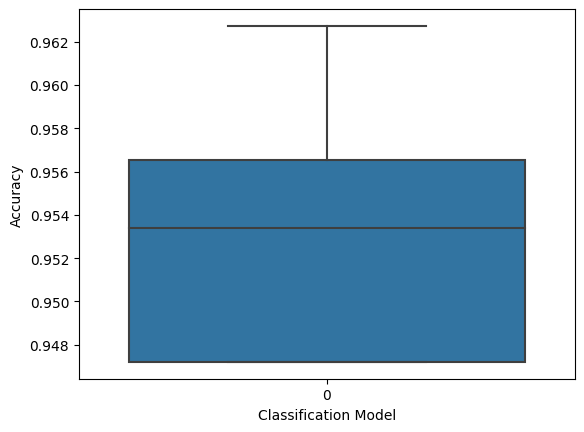

In [94]:
sns.boxplot(all_accuracies[3]).set(xlabel='Classification Model', ylabel='Accuracy')

### PCA Cancer Comparison

In [154]:
data2 = classification_all.iloc[:, 1:]
target2 = classification_all.iloc[:, 0]
scaled_data2 = StandardScaler().fit_transform(data2)
print(scaled_data2.shape)
print(classification_all.shape)
pca2 = PCA(n_components=2)
pca2.fit_transform(scaled_data2.transpose())
print(pca2)
pca2

(3218, 55691)
(3218, 55692)
PCA(n_components=2)


PCA(n_components=2)

[[-0.00986867 -0.00899308 -0.009102   ... -0.035253   -0.03524501
  -0.03438342]
 [ 0.01868871  0.0218631   0.01146487 ...  0.00365815  0.01289949
   0.0037748 ]]
[0.30148403 0.0715112 ]


[Text(0.5, 0, 'PCA 1 (0 Variance)'), Text(0, 0.5, 'PCA 2 (0 Variance)')]

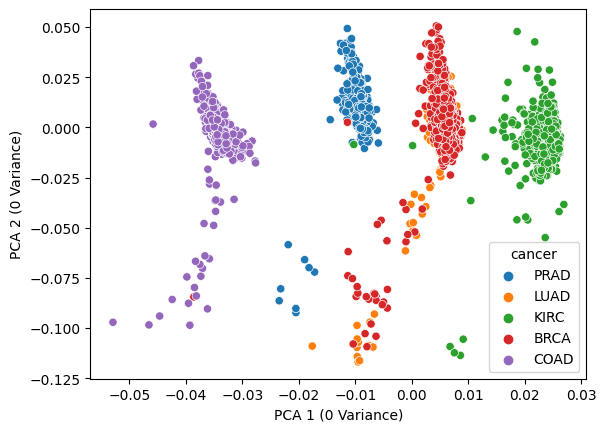

In [17]:
print(pca2.components_)
print(pca2.explained_variance_ratio_)
#Features attribute non existent
#Put the correct gene names in.
ax = sns.scatterplot(data=classification_all, x=pca2.components_[0], y=pca2.components_[1], hue='cancer')
ax.set(xlabel='PCA 1' + f' ({int(pca2.explained_variance_ratio_[0])} Variance)', ylabel='PCA 2' + f' ({int(pca2.explained_variance_ratio_[1])} Variance)')
# sns.scatterplot(data=scaled_data2, x=pca2.feature_names_in_[0], y=pca2.feature_names_in_[1])

[Text(0.5, 0, 'PCA 1 (0 Variance)'), Text(0, 0.5, 'PCA 3 (0 Variance)')]

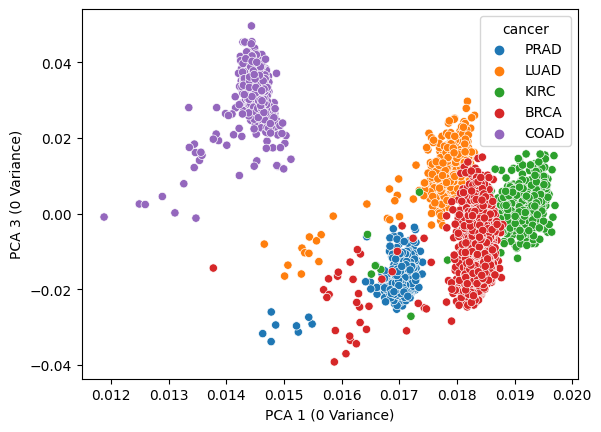

In [433]:
pca3 = PCA(n_components=3)
pca3.fit_transform(data.transpose())
ax1 = sns.scatterplot(data=classification_all, x=pca3.components_[0], y=pca3.components_[2], hue='cancer')
ax1.set(xlabel='PCA 1' + f' ({int(pca3.explained_variance_ratio_[0])} Variance)', ylabel='PCA 3' + f' ({int(pca3.explained_variance_ratio_[2])} Variance)')

<Axes: >

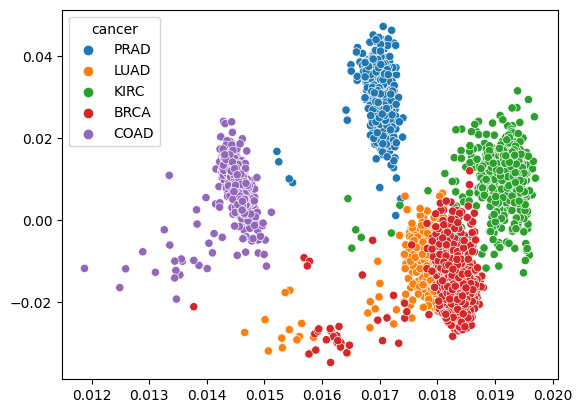

In [25]:
pca4 = PCA(n_components=4)
pca4.fit_transform(data.transpose())
sns.scatterplot(data=classification_all, x=pca4.components_[0], y=pca4.components_[3], hue='cancer')

In [43]:
classification_all.groupby(['cancer'])['cancer'] == 'PRAD'

False

/Users/hhudson/anaconda3/envs/owkin1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

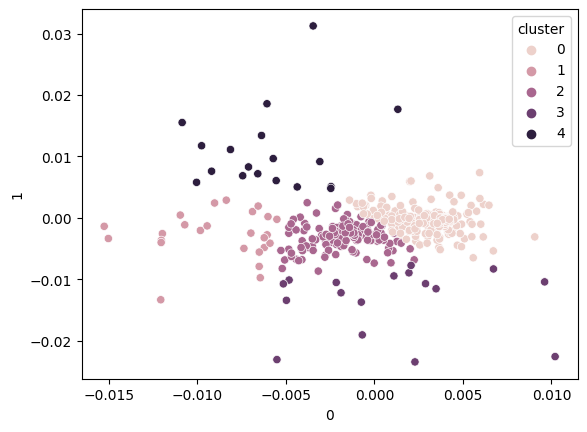

In [182]:
subgrouper = KMeans(n_clusters=5)
pca_sub = PCA(n_components=2)
pre_data = classification_all.iloc[:, 1:]
pre_cancer = classification_all.iloc[:, 0]
pca_sub.fit_transform(pre_data)
pca_data = pca_sub.components_
cancer_df1 = pd.DataFrame(pca_data.transpose())
cancer_df1.insert(0, 'cancer', pre_cancer)
cancer_grouped = cancer_df1.groupby(['cancer'])
One_cancer_type = pd.DataFrame(cancer_grouped.get_group('PRAD'))
One_cancer_type_data = One_cancer_type.iloc[:, 1:]
pred = subgrouper.fit_predict(One_cancer_type_data)
One_cancer_type.insert(0, 'cluster', pred)
sns.scatterplot(data=One_cancer_type, x=One_cancer_type.iloc[:, 2], y=One_cancer_type.iloc[:, 3], hue='cluster')

### DataFrame Creation for Deseq

In [256]:
data_minus_label = classification_all.iloc[:, 1:]
cluster_KMean = KMeans(n_clusters=5)
pred1 = cluster_KMean.fit_predict(data_minus_label)
pred_bool = pred1.astype(bool).astype(int)
sample_list = []
for sample in range(pred_bool.shape[0]):
    sample_list.append('sample' + f'{sample}')
counts_df = pd.DataFrame(data_minus_label)
counts_df['sample']=sample_list
counts_df = counts_df.set_index('sample')
clinical_df = pd.DataFrame({'sample': sample_list, 'cluster': pred_bool})
clinical_df = clinical_df.set_index('sample', drop=True)

In [410]:
def split_df(X, test_size):
    index = X.shape[0]* (1-test_size)
    return X[:index, :], X[index:, :]

def split_1d(X, test_size):
    index = X.shape[0]* (1-test_size)
    return X[:index], X[index:]

### Naive Bayes Acual vs Predicted

In [392]:
print(classification_all.iloc[:, 0][2])
trainx, testx, trainy, testy = train_test_split(classification_all[:, 1:], classification_all[:, 0], test_size=0.3)

PRAD


InvalidIndexError: (slice(None, None, None), slice(1, None, None))

In [411]:
stripped_data = classification_all.iloc[:, 1:]
nb_pca = PCA(n_components=2)
nb_reduced = nb_pca.fit_transform(stripped_data)
#above is reduction of data using PCA
print(type(nb_reduced))
nb_train, nb_test = split_df(nb_reduced, 0.3)
target_train, target_test = split_1d(classification_all.iloc[:, 0], 0.3)
#above is data splitting
#creation of Naive Bayes
nb_compare = BernoulliNB()
# df_temp = pd.DataFrame(nb_reduced)
# df_temp.insert(0, 'cancer', classification_all.iloc[:, 1])
# nb_Xtrain, nb_Xtest, nb_ytrain, nb_ytest = train_test_split(df_temp, test_size=0.3)
# print(nb_Xtrain)
# print(nb_ytrain)
#above is failed data splitting
nb_compare.fit(nb_train, target_train)
nb_predictions = nb_compare.predict(nb_test)
#above is the prediction making
print(nb_predictions.shape)
print(target_test.shape)
#below creates the data frame with data, predictions and actual target value
nb_df = pd.DataFrame(nb_test)
nb_df.insert(0, 'prediction', nb_predictions)
nb_df.insert(1, 'actual', target_test)
print(nb_df)
#combine targets and data back into a dataframe so that it cam be the data=, then can use hue='cancer
fig, axes = plt.subplots(1, 2)
sns.scatterplot(data=nb_df, x=nb_df.iloc[2], y=nb_df.iloc[3], hue='prediction')
sns.scatterplot(data=nb_df, x=nb_df.iloc[2], y=nb_df.iloc[3], hue='actual')
#fix my data splitter, it doesnt do all the columns and bits correctly

<class 'numpy.ndarray'>


TypeError: slice indices must be integers or None or have an __index__ method

     cancer         0         1
0      PRAD -0.009869  0.018689
1      PRAD -0.008993  0.021863
2      PRAD -0.009102  0.011465
3      PRAD -0.009659  0.018816
4      PRAD -0.008444  0.008165
...     ...       ...       ...
3213   COAD -0.035657  0.006030
3214   COAD -0.032881 -0.004213
3215   COAD -0.035253  0.003658
3216   COAD -0.035245  0.012899
3217   COAD -0.034383  0.003775

[3218 rows x 3 columns]


ValueError: Length of values (2896) does not match length of index (3218)

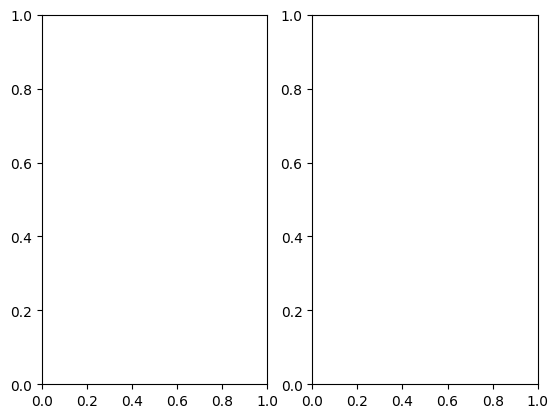

In [156]:
fig, axes = plt.subplots(1, 2)
tabular_data = pd.DataFrame(pca2.components_.transpose())
pre_1 = classification_all.iloc[:, 0]
tabular_data.insert(0, 'cancer', pre_1)
NB2 = BernoulliNB()
NB2.fit(classification_all[train_index], target.iloc[train_index])
NB_accuracies.append(NB2.score(reduced_data[test_index], target.iloc[test_index]))
NB_prediction = NB.predict(reduced_data[train_index])
print(tabular_data)
tabular_data.insert(1, 'prediction', NB_prediction)

# wahoo = np.insert(0, NB_prediction)
# print(wahoo.shape)
# sns.scatterplot(data=classification_all, x= , y= )
# sns.scatterplot(data=classification_all, x= , y= )


### Import Pydeseq2 Packages

In [209]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [ ]:
#load data, aka the two data_sets I create based on the cluster

### Data Filtering

In [259]:
sample_to_keep = ~clinical_df.cluster.isna()
counts_df = counts_df.loc[sample_to_keep]
clinical_df = clinical_df.loc[sample_to_keep]

This filters out data that has NaN entries.

In [ ]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

Filters out genes that have less than 10 read counts in total.

### Single Factor Analysis

In [296]:
counts_df = counts_df.astype(int)
dds = DeseqDataSet(counts=counts_df, clinical=clinical_df, design_factors='cluster', refit_cooks=True)
dds.deseq2()

Fitting size factors...
... done in 24.76 seconds.

Fitting dispersions...
... done in 107.44 seconds.

Fitting dispersion trend curve...
... done in 20.95 seconds.

Fitting MAP dispersions...
... done in 462.04 seconds.

Fitting LFCs...
... done in 583.82 seconds.

Refitting 0 outliers.



Initializes DeseqDataSet and fits disperisions and log2 fold change.

In [310]:
print(dds.varm["LFC"])

           intercept  cluster_1_vs_0
5_8S_rRNA   2.256494       -0.069614
5S_rRNA     2.258279       -0.025425
7SK         2.557627        0.100134
A1BG        2.434840        0.213063
A1BG-AS1    2.452609        0.217494
...              ...             ...
ZYG11B      2.711379        0.147216
ZYX         2.886266        0.073090
ZYXP1       2.256494       -0.071036
ZZEF1       2.779507        0.100290
ZZZ3        2.735633        0.124306

[55691 rows x 2 columns]


### Statistical Analysis

In [297]:
print(dds)
stat_res = DeseqStats(dds)
stat_res.summary()

AnnData object with n_obs × n_vars = 3218 × 55691
    obs: 'cluster'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'
Running Wald tests...
... done in 684.88 seconds.

Log2 fold change & Wald test p-value: cluster 1 vs 0


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5_8S_rRNA,9.005096,-0.100432,0.022359,-4.491754,7.063892e-06,1.513350e-05
5S_rRNA,9.362858,-0.036681,0.022255,-1.648207,9.931027e-02,1.143460e-01
7SK,14.048487,0.144462,0.018971,7.614960,2.637724e-14,1.026394e-13
A1BG,13.697945,0.307384,0.020009,15.362405,2.925170e-53,1.147223e-51
A1BG-AS1,13.997978,0.313778,0.019826,15.826685,2.036728e-56,9.261697e-55
...,...,...,...,...,...,...
ZYG11B,17.071692,0.212388,0.017506,12.132249,7.126500e-34,1.038143e-32
ZYX,19.080679,0.105447,0.016129,6.537509,6.255191e-11,2.049887e-10
ZYXP1,8.994382,-0.102483,0.022362,-4.582913,4.585433e-06,1.113148e-05
ZZEF1,17.550189,0.144688,0.016979,8.521816,1.570714e-17,7.445918e-17


In [303]:
stat_res.lfc_shrink(coeff="cluster_1_vs_0")
print(stat_res.shrunk_LFCs)
stat_res_1_vs_0 = DeseqStats(dds, contrast=["cluster", '1', '0'], n_cpus=8)
stat_res_1_vs_0.summary()

Fitting MAP LFCs...
... done in 16.36 seconds.

Shrunk Log2 fold change & Wald test p-value: cluster 1 vs 0


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5_8S_rRNA,9.005096,-0.14427,0.06606,-4.491754,7.063892e-06,1.513350e-05
5S_rRNA,9.362858,-0.14427,0.06606,-1.648207,9.931027e-02,1.143460e-01
7SK,14.048487,-0.14427,0.06606,7.614960,2.637724e-14,1.026394e-13
A1BG,13.697945,-0.14427,0.06606,15.362405,2.925170e-53,1.147223e-51
A1BG-AS1,13.997978,-0.14427,0.06606,15.826685,2.036728e-56,9.261697e-55
...,...,...,...,...,...,...
ZYG11B,17.071692,-0.14427,0.06606,12.132249,7.126500e-34,1.038143e-32
ZYX,19.080679,-0.14427,0.06606,6.537509,6.255191e-11,2.049887e-10
ZYXP1,8.994382,-0.14427,0.06606,-4.582913,4.585433e-06,1.113148e-05
ZZEF1,17.550189,-0.14427,0.06606,8.521816,1.570714e-17,7.445918e-17


True
Running Wald tests...
... done in 731.42 seconds.

Log2 fold change & Wald test p-value: cluster 1 vs 0


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5_8S_rRNA,9.005096,-0.100432,0.022359,-4.491754,7.063892e-06,1.513350e-05
5S_rRNA,9.362858,-0.036681,0.022255,-1.648207,9.931027e-02,1.143460e-01
7SK,14.048487,0.144462,0.018971,7.614960,2.637724e-14,1.026394e-13
A1BG,13.697945,0.307384,0.020009,15.362405,2.925170e-53,1.147223e-51
A1BG-AS1,13.997978,0.313778,0.019826,15.826685,2.036728e-56,9.261697e-55
...,...,...,...,...,...,...
ZYG11B,17.071692,0.212388,0.017506,12.132249,7.126500e-34,1.038143e-32
ZYX,19.080679,0.105447,0.016129,6.537509,6.255191e-11,2.049887e-10
ZYXP1,8.994382,-0.102483,0.022362,-4.582913,4.585433e-06,1.113148e-05
ZZEF1,17.550189,0.144688,0.016979,8.521816,1.570714e-17,7.445918e-17


Applying threshold to data.

In [358]:
stat_res_1_vs_0_filtered = stat_res_1_vs_0.results_df[stat_res_1_vs_0.results_df['padj'] < 0.5]
stat_res_1_vs_0_filtered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5_8S_rRNA,9.005096,-0.100432,0.022359,-4.491754,7.063892e-06,1.513350e-05
5S_rRNA,9.362858,-0.036681,0.022255,-1.648207,9.931027e-02,1.143460e-01
7SK,14.048487,0.144462,0.018971,7.614960,2.637724e-14,1.026394e-13
A1BG,13.697945,0.307384,0.020009,15.362405,2.925170e-53,1.147223e-51
A1BG-AS1,13.997978,0.313778,0.019826,15.826685,2.036728e-56,9.261697e-55
...,...,...,...,...,...,...
ZYG11B,17.071692,0.212388,0.017506,12.132249,7.126500e-34,1.038143e-32
ZYX,19.080679,0.105447,0.016129,6.537509,6.255191e-11,2.049887e-10
ZYXP1,8.994382,-0.102483,0.022362,-4.582913,4.585433e-06,1.113148e-05
ZZEF1,17.550189,0.144688,0.016979,8.521816,1.570714e-17,7.445918e-17


Finding the three genes with the highest log fold changes.

In [385]:
sorted_stat_1_vs_0 = stat_res_1_vs_0_filtered.iloc[:, 1].sort_values(ascending=False)
top_three_genes = sorted_stat_1_vs_0[:3].index
top_three_genes

Index(['LRP2', 'IRX3', 'HPN'], dtype='object')

LRP2 is only druggable by ligand based assesment, and is involved in five pathways. The first is the vitaming D metabolism, then also HDL remodeling, plasma lipoprotein clearance, plasma lipoprotein assembkly, remodeling, and clearance and finally the metabolism fo steroids. IRX3 is not druggable and is involved in the regulation of gene expression in beta cells. HPN is involved in three pathways, the signaling by MST1, MET receptor activation, and signaling by receptor Tyrosine Kinases. The gene is tractible by bioactive compounds, enzyme and has a druggable structure.

### Simple Neural Network

Import Libraries

In [3]:
# import 


import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression

import jax
import jax.numpy as jnp
from jax import grad

In [4]:
# data loading
classification_all
X, Y = make_regression(n_features=20, n_samples=1000)
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.15)

In [17]:
from sklearn.preprocessing import OrdinalEncoder


/var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gn/T/ipykernel_46047/248302713.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = OrdinalEncoder().fit_transform(y_first[:, None])


((3218, 55691), (3218, 1))

In [27]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST
from sklearn.preprocessing import OrdinalEncoder


def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)
    
class Cast(object):
  def __call__(self, pic):
    return np.array(pic, dtype=jnp.float32)
  

class MyDataset(data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)



X_full = classification_all.iloc[:, 1:].values
X = PCA(n_components=20).fit_transform(X_full)
Y_first = classification_all.iloc[:, 0]
Y = OrdinalEncoder().fit_transform(Y_first[:, None])

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)

train_dataset = MyDataset(X_train,Y_train, transform=Cast())
val_dataset = MyDataset(X_val,Y_val, transform=Cast())

training_generator = NumpyLoader(train_dataset, batch_size=16, num_workers=0)
validation_generator = NumpyLoader(val_dataset, batch_size=64, num_workers=0)

/var/folders/hs/9wxtjrjx2k718tlbtzyfl1dm0000gn/T/ipykernel_46047/2848822907.py:62: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = OrdinalEncoder().fit_transform(Y_first[:, None])


In [36]:

# function def
from typing import Sequence

import jax
import jax.numpy as jnp
import flax.linen as nn

class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

model = MLP([12, 8, 5])
fake_batch = jnp.ones((16, 20))
params = model.init(jax.random.PRNGKey(0), fake_batch)


In [43]:
import otpax

x, y = next(iter(training_generator))
logits = model.apply(params, x)

optax.

ModuleNotFoundError: No module named 'otpax'

  Using cached numpy-1.24.3-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
ERROR: Cannot uninstall numpy 1.24.3, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.24.3'.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# training

max_epoch = 10
loss_train = []
loss_val = []
batch_size = 16
learning_rate = np.array(0.0003)

rng = jax.random.PRNGKey(0)
params =  init(rng, n_features=X.shape[1], n_output=1, n_neurons_per_layers = [32, 32])
list_idx = np.arange(x_train.shape[0])

for epoch in range(max_epoch):
    np.random.shuffle(list_idx)
    for i in range(len(list_idx)//batch_size):
        batch_idx = list_idx[batch_size*i:batch_size*(i+1)]
        grad = grad_loss(params, x_train[batch_idx, :],y_train[batch_idx])
        params = update_params(params, grad, learning_rate=learning_rate)
    #log
    loss_train.append(loss(params, x_train,y_train))
    loss_val.append(loss(params,x_val,y_val ))

In [ ]:
# plot

import matplotlib.pyplot as plt
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend(loc='best')

In [ ]:
class NeuralNetwork:

    def __init__(self, rng, n_features, n_output, n_neurons_per_layers):
        self.n_features = n_features
        self.n_output = n_output
        self.n_neurons_per_layers = n_neurons_per_layers
        self.params = []
        n_neurons_pre = self.n_features
        for n_neurons in self.n_neurons_per_layers:
            rng, rng_ = jax.randomsplit(rng)
            self.params.append(jax.random.normal(rng_, shape=(n_neurons_pre, n_neurons))*0.1)
            n_neurons_pre = n_neurons
        rng, rng_ = jax.random.split(rng)
        self.params.append(jax.random.normal(rng_, shape=(n_output, n_neurons_pre))*0.1)

    def model(self, x):
        a = x
        for w in self.params[:-1]:
            z = a@w
            a = jax.nn.relu(z)

        return jnp.vdot(a, params[-1])
    
    def loss(self, batch_x, batch_y):
        def squared_error(x,y):
            return (y - self.model(x))**2
        
        return jnp.mean(jax.vmap(squared_error)(batch_x, batch_y))
    
    def grad_loss(self):
        return jax.jit(jax.grad(loss, argnums=(0,)))
    
    def update_params(self, grads, learning_rate):
        new_params = []
        for grad, w in zip(grads[0], params):
            new_params.append(w - learning_rate * grad)
        return new_params